In [241]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
# import visuals as vs
pd.options.mode.chained_assignment = None
# import xml.etree.cElementTree as et
# import xmltodict

Function to read soup

In [242]:
def soup_to_df(s):
    dfcols = ['outcode', 'last_published_date','latitude', 'longitude', 'post_town', 'num_bathrooms', 'num_bedrooms', 'num_floors', 
              'num_recepts', 'property_type', 'street_name', "price"]
    df_xml = pd.DataFrame(columns=dfcols)

    for node in s.find_all("listing"):
        outcode =  node.find('outcode').get_text()
        last_published_date = node.find('last_published_date').get_text()
        latitude = node.find('latitude').get_text()
        longitude = node.find('longitude').get_text()
        post_town = node.find('post_town').get_text()
        num_bathrooms = node.find('num_bathrooms').get_text()
        num_bedrooms = node.find('num_bedrooms').get_text()
        num_floors = node.find('num_floors').get_text()
        num_recepts = node.find('num_recepts').get_text()
        property_type = node.find('property_type').get_text()
        street_name = node.find('street_name').get_text()
        price = node.find('price').get_text()

        df_xml = df_xml.append(pd.Series([outcode, float(latitude), float(longitude), post_town, last_published_date, int(num_bathrooms),
                                          int(num_bedrooms), int(num_floors), int(num_recepts), property_type, street_name, int(price)], index=dfcols),ignore_index=True)
    
    return df_xml
# df = pd.read_html(str(table))[0]
# print(df[0].to_json(orient='records'))

Build the DF contain all data

In [ ]:
dfcols = ['outcode', 'latitude', 'longitude', 'post_town', 'last_published_date', 'num_bathrooms', 'num_bedrooms', 'num_floors', 
              'num_recepts', 'property_type', 'street_name', "price"]
df_all = pd.DataFrame(columns=dfcols)
for i in range(1, 58):
    baseurl = f"https://api.zoopla.co.uk/api/v1/property_listings?api_key=9zpbeza9n858g3u2g633u3rb&county=Somerset&country=England&listing_status=sale&include_sold=1&page_number={i}&page_size=100"
    page = requests.get(baseurl)
    soup = BeautifulSoup(page.content)
    df = soup_to_df(soup)
    df_all = pd.concat([df_all, df], axis = 0) 
# df_all.to_csv("estates.csv")

C:\Users\Ted_Liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [ ]:
df_all = pd.read_csv("estates.csv")

In [ ]:
df_all.info()
df_all.head()

EDA

In [ ]:
# for outcode
# d = df_all["outcode"].groupby(df_all["outcode"])
# ax = sns.barplot(x=d.size().index, y=d.size().values)

# ax = sns.countplot(x = "outcode", data = df_all)
# plt.figure(figsize=(15,8))
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=5, rotation=40, ha="right")
# ax.set_xticklabels(ax.get_xticklabels(), )
# plt.tight_layout()
# plt.show()
df_all = df_all.drop(columns = ["Unnamed: 0", "description", "shared_occupancy", "details_url", "first_published_date", "shared_occupancy"])

for i in range(1, len(df_all.columns)):
    name = df_all.columns[i]
    print(len(df_all[name].unique()), name, df_all[name].unique())
# df_all["outcode"].unique()

In [ ]:
df_all = df_all.drop(columns = ["address", "street_name"])
# display(type(df_all["last_published_date"][0]))
# display(df_all["last_published_date"][0])
for i in range(len(df_all["last_published_date"])):
    df_all.loc[i, "last_published_date"] = df_all.loc[i, "last_published_date"][:4]

In [ ]:
df_all["last_published_date"].unique()

Data preprocessing

In [ ]:
df_all.head()

In [ ]:
df_all[["num_bathrooms", "num_bedrooms", "num_floors", "num_recepts", "price"]] = df_all[["num_bathrooms", "num_bedrooms", "num_floors", "num_recepts", "price"]].astype("int")
df_all.info()

In [ ]:
# std_dev = 3
# df = df_all[(np.abs(stats.zscore(df)) < float(std_dev)).all(axis=1)]
# df.plot(figsize=(18,5))

In [ ]:
df_all["county"] = df_all["county"].fillna("N")
df_all["new_home"] = df_all["new_home"].fillna("N")
df_all["post_town"] = df_all["post_town"].fillna("N")
df_all["property_type"] = df_all["property_type"].fillna("N")

df_drop_zeroprice = df_all[df_all["price"] != 0]
df_drop_zeroprice["log_price"] = np.log(df_drop_zeroprice["price"])
df_drop_zeroprice = df_drop_zeroprice.drop(columns = ["price"])
df_drop_zeroprice.info()

Relationship between location and log_price

In [ ]:
sns.relplot(x="longitude", y="latitude", hue="log_price", data=df_drop_zeroprice)

In [ ]:
sns.relplot(x="num_bedrooms", y="log_price", data=df_drop_zeroprice)
sns.relplot(x="num_bathrooms", y="log_price", data=df_drop_zeroprice)
sns.relplot(x="num_floors", y="log_price", data=df_drop_zeroprice)
sns.relplot(x="num_recepts", y="log_price", data=df_drop_zeroprice)

In [ ]:
sns.catplot(x="property_type", y="log_price", data=df_drop_zeroprice)
plt.xticks(rotation=90)

In [ ]:
# plt.figure(figsize=(10,10))
# fig,ax=plt.subplots(figsize=(15,5))
sns.catplot(x="post_town", y="log_price", data=df_drop_zeroprice, height=4, aspect=3)
plt.xticks(rotation="vertical")
# plt.show()

In [ ]:
sns.distplot(df_all['price'], color = 'blue', hist=True, kde=True, bins=int(180/5))

In [ ]:
sns.distplot(df_drop_zeroprice['log_price'], color = 'red', hist=True, kde=True, bins=int(180/5))

choose columns (categories)

In [15]:
df_drop_zeroprice[df_drop_zeroprice["new_home"] == True].count()

county                 493
last_published_date    493
latitude               493
longitude              493
new_home               493
num_bathrooms          493
num_bedrooms           493
num_floors             493
num_recepts            493
outcode                493
post_town              493
property_type          493
log_price              493
dtype: int64

In [16]:
df_drop_zeroprice = df_drop_zeroprice.drop(columns = ["new_home"])

P-value to choose columns (continus)

In [19]:
#Adding constant column of ones, mandatory for sm.OLS model
x = df_drop_zeroprice.drop(columns = ["log_price", "county", "last_published_date", "outcode", "post_town", "property_type"])
y = df_drop_zeroprice[["log_price"]]
x_1 = sm.add_constant(x)
# #Fitting sm.OLS model
model = sm.OLS(np.array(y), np.array(x_1)).fit()
model.pvalues

array([1.15263928e-01, 2.23264296e-17, 6.43275486e-11, 5.39683752e-06,
       0.00000000e+00, 5.58872909e-01, 1.75894482e-48])

In [21]:
def backwardElimination(x, y, sl):
    cols = list(x.columns)
    pmax = 1
    while (len(cols)>0):
        p= []                                                                                    
        X_1 = x[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols
    print(selected_features_BE)
backwardElimination(x, y, 0.05)

['latitude', 'longitude', 'num_bathrooms', 'num_bedrooms', 'num_recepts']


In [41]:
# drop the column num_floors
df_drop_zeroprice = df_drop_zeroprice.drop(columns = ["num_floors"])
x = x.drop(columns = ["num_floors"])

Correlation

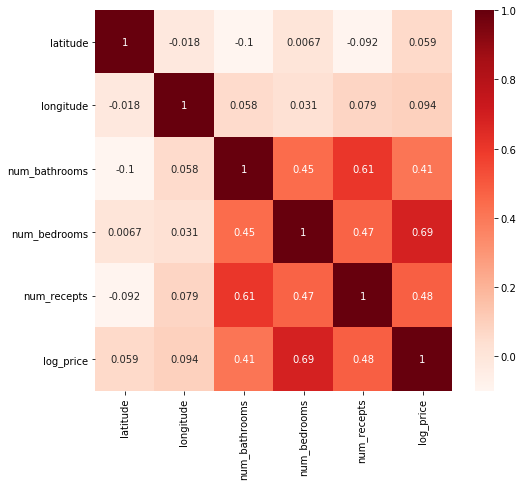

In [23]:
#Using Pearson Correlation
plt.figure(figsize=(8,7))
cor = df_drop_zeroprice.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [24]:
cor_target = abs(cor["log_price"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

num_bedrooms    0.686463
log_price       1.000000
Name: log_price, dtype: float64

In [166]:
df_drop_zeroprice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5853 entries, 0 to 5867
Data columns (total 11 columns):
county                 5853 non-null object
last_published_date    5853 non-null object
latitude               5853 non-null float64
longitude              5853 non-null float64
num_bathrooms          5853 non-null int32
num_bedrooms           5853 non-null int32
num_recepts            5853 non-null int32
outcode                5853 non-null object
post_town              5853 non-null object
property_type          5853 non-null object
log_price              5853 non-null float64
dtypes: float64(3), int32(3), object(5)
memory usage: 480.1+ KB


Split the train and test dataframe

In [25]:
feature_df = df_drop_zeroprice.drop(columns = ["log_price"])
price_df = df_drop_zeroprice[["log_price"]]

feature_df_dummy = pd.get_dummies(feature_df, prefix_sep='_', drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(feature_df_dummy, price_df, test_size=0.2, random_state=1)

price_df.head()
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4682 entries, 3436 to 5171
Columns: 144 entries, latitude to property_type_Villa
dtypes: float64(2), int32(3), uint8(139)
memory usage: 800.1 KB


In [26]:
x_train.head()

,latitude,longitude,num_bathrooms,num_bedrooms,num_recepts,county_Bristol,county_Devon,county_Dorset,county_N,county_North Somerset,...,property_type_Mobile/park home,property_type_N,property_type_Parking/garage,property_type_Semi-detached bungalow,property_type_Semi-detached house,property_type_Studio,property_type_Terraced bungalow,property_type_Terraced house,property_type_Town house,property_type_Villa
3436,51.338020,-2.957877,2,3,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2551,51.034737,-3.069013,0,3,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5079,51.254253,-2.491344,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1213,50.989086,-2.408865,1,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1724,51.203728,-3.485259,2,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Linear regression analysis

Best prediction

In [60]:
def pred_score(df_pred, df_test):
    count = 0
    for i in range(0, len(df_pred)):
        if np.exp(np.array(df_pred)[i][0]) >= np.exp(np.array(df_test)[i][0])*0.8 and  np.exp(np.array(df_pred)[i][0]) <= np.exp(np.array(df_test)[i][0])*1.2:
            count += 1
    return count/len(df_pred)



In [58]:
np.exp([1,2,3])

array([ 2.71828183,  7.3890561 , 20.08553692])

Model Score

In [29]:
# y_test = ravel(y_test)
# x_train.head()
x_test.head()
score_list = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(feature_df_dummy, price_df, test_size=0.2)
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    score_list.append(lr.score(x_test, y_test))
print(max(score_list))

0.7218052628248336


Predict Score

In [62]:
pred_list = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(feature_df_dummy, price_df, test_size=0.2)
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    pred_list.append(pred_score(pred, y_test))
print(max(pred_list))

0.6242527754056362


In [158]:
error_list = []
x_train, x_test, y_train, y_test = train_test_split(feature_df_dummy, price_df, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
for i in range(0, len(y_test)):
    error_list.append(np.exp(np.array(pred)[i][0]) - np.exp(np.array(y_test)[i][0]))

(array([-2000000., -1500000., -1000000.,  -500000.,        0.,   500000.,
         1000000.,  1500000.,  2000000.]),
 <a list of 9 Text xticklabel objects>)

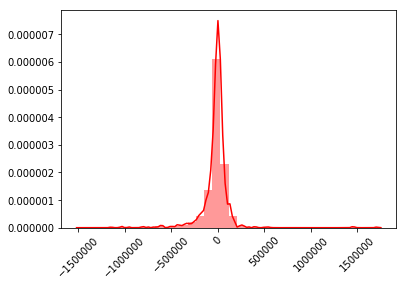

In [160]:
error_list = np.array(error_list)
error_list[error_list >= 1E308] = 0
s = sns.distplot(error_list, color = 'red', hist=True, kde=True, bins=int(180/5))
# s.set_xticklabels(s.get_xticklabels(),rotation=30)
# plt.setp(s.get_xticklabels(), rotation=45)
plt.xticks(rotation=45)

Ridge regression

In [45]:
# Standarize features
scaler = StandardScaler()
x= x_train.astype(float)
x_std = scaler.fit_transform(x)
# x.head()

In [46]:
#Set the different values of alpha to be tested
alphas = np.arange(0.01, 10, 0.01).tolist()
alpha_ridge = RidgeCV(alphas)
# Fit the linear regression
model_cv = alpha_ridge.fit(x_std, y_train)
#best alpha
best_a = model_cv.alpha_
best_a

9.07

Model socre

In [48]:
score_list = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(feature_df_dummy, price_df, test_size=0.2)
    rr = Ridge(alpha=best_a)
    rr.fit(x_train, y_train)
    score_list.append(rr.score(x_test, y_test))
print(max(score_list))

0.7288268259388152


Predict Score

In [64]:
pred_list = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(feature_df_dummy, price_df, test_size=0.2)
    rr = Ridge(alpha=best_a)
    rr.fit(x_train, y_train)
    pred = rr.predict(x_test)
    pred_list.append(pred_score(pred, y_test))
print(max(pred_list))

0.6353543979504697


Error plot

In [163]:
error_list = []
x_train, x_test, y_train, y_test = train_test_split(feature_df_dummy, price_df, test_size=0.2, random_state=42)
rr = Ridge(alpha=best_a)
rr.fit(x_train, y_train)
pred = rr.predict(x_test)
for i in range(0, len(y_test)):
    error_list.append(np.exp(np.array(pred)[i][0]) - np.exp(np.array(y_test)[i][0]))

(array([-2000000., -1500000., -1000000.,  -500000.,        0.,   500000.,
         1000000.,  1500000.,  2000000.,  2500000.]),
 <a list of 10 Text xticklabel objects>)

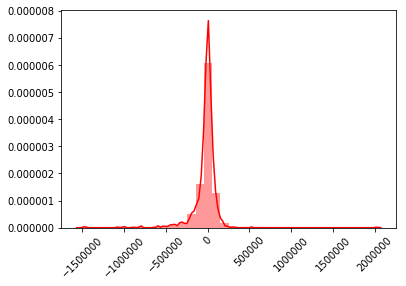

In [164]:
error_list = np.array(error_list)
error_list[error_list >= 1E308] = 0
s = sns.distplot(error_list, color = 'red', hist=True, kde=True, bins=int(180/5))
# s.set_xticklabels(s.get_xticklabels(),rotation=30)
# plt.setp(s.get_xticklabels(), rotation=45)
plt.xticks(rotation=45)